In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PRATICAL 1: EDA

The goal of this section is to investigate the data to find hidden patterns and biases like the huge gap between famous and unpopular movies so we can understand the challenges before building our recommendation model.

# 1-Import the requirement librairies

In [3]:
pip install powerlaw

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw
from scipy.sparse import csr_matrix
from dotenv import load_dotenv


# Configuration of all my plots
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


# 2-Import the requirement Dataset

In [5]:
# # 1. Load the environment variables
# load_dotenv()
# # 2. Get the base path
# base_dir = os.getenv("DATA_DIR_PATH")
base_dir='/content/drive/MyDrive/ML_at_scale/ml-32m'

In [6]:
# --- Paths Configuration ---
BASE_DIR = '/content/drive/MyDrive/ML_at_scale'
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
DATA_DIR = os.path.join(BASE_DIR, 'ml-32m')
RATINGS_PATH = os.path.join(DATA_DIR, 'ratings.csv')

# Create the figures directory if it doesn't exist
if not os.path.exists(FIGURES_DIR):
    os.makedirs(FIGURES_DIR)
    print(f"[-] Created directory: {FIGURES_DIR}")
else:
    print(f"[-] Saving results to: {FIGURES_DIR}")

[-] Saving results to: /content/drive/MyDrive/ML_at_scale/figures


In [7]:
movies_df = pd.read_csv(os.path.join(base_dir, 'movies.csv'))

In [8]:
links_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/links.csv')

In [9]:
ratings_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/ratings.csv')

In [10]:
tags_df=pd.read_csv('/content/drive/MyDrive/ML_at_scale/ml-32m/tags.csv')

# 3-Data description

In [11]:
#print the shape of the data
print(f"the link data has {links_df.shape[0]} records and {links_df.shape[1]} features" )
print(f"the movie data has {movies_df.shape[0] }records and {movies_df.shape[1]}features")
print(f"the ratings data has {ratings_df.shape[0]}records and {ratings_df.shape[1]} features")
print(f"the tags data has {tags_df.shape[0]} records and {tags_df.shape[1]} features")

the link data has 87585 records and 3 features
the movie data has 87585records and 3features
the ratings data has 32000204records and 4 features
the tags data has 2000072 records and 4 features


In [12]:
#print the 5 first entries in the movies data
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

In [13]:
#print the 5 first entries in the link data
links_df.head()

movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0

In [14]:
ratings_df.head()

userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858

In [15]:
tags_df.head()

userId  movieId          tag   timestamp
0      22    26479  Kevin Kline  1583038886
1      22    79592     misogyny  1581476297
2      22   247150   acrophobia  1622483469
3      34     2174        music  1249808064
4      34     2174        weird  1249808102

In [16]:
#This Class is for the EDA analysis we just need to add the function you want to do your analysis

class MovieLensEDA:
    """
    Advanced Exploratory Data Analysis engine for MovieLens Datasets.
    Generates  PDFs .
    """

    def __init__(self, data_dir: str):
        self.data_dir = data_dir
        self.ratings_path = os.path.join(data_dir, 'ratings.csv')
        self.movies_path = os.path.join(data_dir, 'movies.csv')
        self.df_ratings = None
        self.df_movies = None
        self._output_dir = "figures/eda"
        os.makedirs(self._output_dir, exist_ok=True)

    def load_data(self):
        """Loads data efficiently using specified dtypes to save memory."""
        print(f"[-] Loading data from {self.data_dir}...")

        # Optimize types
        dtypes = {
            'userId': 'int32',
            'movieId': 'int32',
            'rating': 'float32',
            'timestamp': 'int64'
        }

        self.df_ratings = pd.read_csv(self.ratings_path, dtype=dtypes)
        self.df_movies = pd.read_csv(self.movies_path)

        # Convert timestamp to datetime objects
        self.df_ratings['date'] = pd.to_datetime(self.df_ratings['timestamp'], unit='s')

        print(f"[+] Data Loaded.")
        print(f"    Ratings: {self.df_ratings.shape}")
        print(f"    Users: {self.df_ratings['userId'].nunique()}")
        print(f"    Items: {self.df_ratings['movieId'].nunique()}")

    def plot_rating_distribution(self):
        """Plots the global distribution of ratings."""
        plt.figure(figsize=(8, 5))
        ax = sns.countplot(x='rating', data=self.df_ratings, palette="viridis", hue='rating', legend=False)
        ax.set_title("Global Rating Distribution")
        ax.set_xlabel("Rating")
        ax.set_ylabel("Count")
        self._save_plot("rating_distribution")

    def plot_long_tail(self):
        """Log-Log plot for Power Law detection."""
        item_counts = self.df_ratings.groupby('movieId').size().sort_values(ascending=False).values

        plt.figure(figsize=(10, 6))
        plt.plot(item_counts, color='blue', linewidth=2, label="Actual Data")
        plt.title("Long Tail Distribution (Item Popularity)")
        plt.xlabel("Item Rank (Sorted by Popularity)")
        plt.ylabel("Number of Ratings")
        plt.xscale('log')
        plt.yscale('log')

        # Theoretical reference
        x = np.arange(1, len(item_counts) + 1)
        y_ref = item_counts[0] * (x ** -0.8)
        plt.plot(x, y_ref, 'r--', label='Power Law Reference ($x^{-0.8}$)')

        plt.legend()
        plt.grid(True, which="both", ls="-", alpha=0.5)
        self._save_plot("long_tail_log_log")

    def plot_user_activity(self):
        """Plots User Degree Distribution."""
        user_counts = self.df_ratings.groupby('userId').size().sort_values(ascending=False).values

        plt.figure(figsize=(10, 6))
        plt.plot(user_counts, color='green', linewidth=2)
        plt.title("User Activity Distribution")
        plt.xlabel("User Rank")
        plt.ylabel("Number of Ratings Given")
        plt.xscale('log')
        plt.yscale('log')
        plt.grid(True, which="both", ls="-", alpha=0.5)
        self._save_plot("user_activity_log_log")

    def plot_temporal_evolution(self):
        """Time series of ratings."""
        temp_df = self.df_ratings.set_index('date')
        monthly_counts = temp_df.resample('ME').size() # 'ME' is month end

        plt.figure(figsize=(12, 6))
        monthly_counts.plot(color='purple', linewidth=1.5)
        plt.title("Evolution of Number of Ratings Over Time")
        plt.xlabel("Year")
        plt.ylabel("Number of Ratings (Monthly)")
        self._save_plot("temporal_evolution")

    def plot_heatmap_sparsity(self, n_sample=100):
        """Heatmap of top users/items."""
        top_users = self.df_ratings['userId'].value_counts().nlargest(n_sample).index
        top_items = self.df_ratings['movieId'].value_counts().nlargest(n_sample).index

        sample_df = self.df_ratings[
            (self.df_ratings['userId'].isin(top_users)) &
            (self.df_ratings['movieId'].isin(top_items))
        ]

        pivot = sample_df.pivot(index='userId', columns='movieId', values='rating')

        plt.figure(figsize=(12, 10))
        sns.heatmap(pivot, cmap="YlGnBu", cbar=True, xticklabels=False, yticklabels=False)
        plt.title(f"Interaction Heatmap (Top {n_sample} Users x Top {n_sample} Items)")
        plt.xlabel("Movies (Popular)")
        plt.ylabel("Users (Active)")
        self._save_plot("sparsity_heatmap")

    def plot_mean_rating_vs_popularity(self):
        """Correlation between popularity and average rating."""
        stats = self.df_ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
        stats.columns = ['count', 'mean']
        stats = stats[stats['count'] > 50]

        plt.figure(figsize=(10, 6))
        sns.scatterplot(x='count', y='mean', data=stats, alpha=0.3, edgecolor=None)
        plt.xscale('log')
        plt.title("Average Rating vs. Popularity (Log Scale)")
        plt.xlabel("Number of Ratings (Log)")
        plt.ylabel("Average Rating")

        # Trend line
        z = np.polyfit(np.log(stats['count']), stats['mean'], 1)
        p = np.poly1d(z)
        plt.plot(stats['count'], p(np.log(stats['count'])), "r--", linewidth=2, label="Trend")
        plt.legend()
        self._save_plot("correlation_pop_vs_rating")

    def _save_plot(self, filename):
        """
        Saves the current figure in both PNG (for Web) and PDF (for LaTeX).
        """


        #  Save PDF
        filename_pdf = filename + '.pdf'
        path_pdf = os.path.join(self._output_dir, filename_pdf)
        plt.savefig(path_pdf, format='pdf', bbox_inches='tight')

        print(f"    [Saved {filename_pdf} (PDF)")
        plt.close()

    def run_all(self):
        self.load_data()
        self.plot_rating_distribution()
        self.plot_long_tail()
        self.plot_user_activity()
        self.plot_temporal_evolution()
        self.plot_heatmap_sparsity()
        self.plot_mean_rating_vs_popularity()
        print("[+] EDA Complete.")

In [17]:
if __name__ == "__main__":
    # Ensure you have the data in the directory
    eda = MovieLensEDA(data_dir="/content/drive/MyDrive/ML_at_scale/ml-32m/")
    eda.run_all()

[-] Loading data from /content/drive/MyDrive/ML_at_scale/ml-32m/...
[+] Data Loaded.
    Ratings: (32000204, 5)
    Users: 200948
    Items: 84432
    [Saved rating_distribution.pdf (PDF)
    [Saved long_tail_log_log.pdf (PDF)
    [Saved user_activity_log_log.pdf (PDF)
    [Saved temporal_evolution.pdf (PDF)
    [Saved sparsity_heatmap.pdf (PDF)
    [Saved correlation_pop_vs_rating.pdf (PDF)
[+] EDA Complete.


In [18]:

user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_id_map = {old: new for new, old in enumerate(user_ids)}
movie_id_map = {old: new for new, old in enumerate(movie_ids)}

#  4-Exploratory Data Analysis of Ratings (ratings.csv)

In [19]:
#Define the path where to save the plots
FIGURES_DIR = '/content/drive/MyDrive/ML_at_scale/figures'

In [20]:
# Descriptive statistics of ratings
print("Descriptive statistics of ratings:")
print(ratings_df['rating'].describe())



Descriptive statistics of ratings:
count    3.200020e+07
mean     3.540396e+00
std      1.058986e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


Interpretation:


*  describe() shows  the mean, standard deviation, and quartiles
of the ratings. A mean around 3.5 is showing a user tendency to rate positively.

/tmp/ipython-input-1210074922.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings_df, x='rating', palette='viridis')


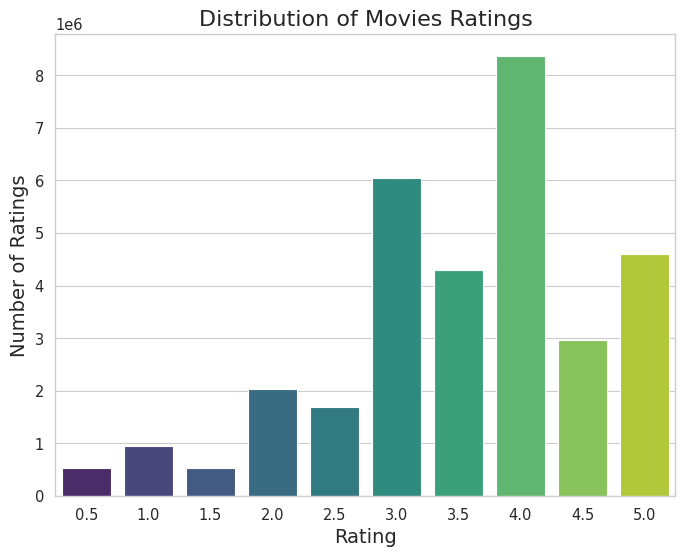

In [21]:
# Distribution of rating frequency

# Setup the figure
plt.figure(figsize=(8, 6))

# Create the plot
sns.countplot(data=ratings_df, x='rating', palette='viridis')

# Add labels
plt.title('Distribution of Movies Ratings')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

# Save as PDF
# bbox_inches='tight' ensures labels aren't cut off
save_path = os.path.join(FIGURES_DIR, 'ratings_distribution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

Interpretation:

* The histogram or countplot visualizes the frequency of each rating for the movies. we can see  certain ratings (like 4.0 or 3.0) are more frequent.

#5- Analysis of Movies and Genres (movies.csv)

In [22]:
# Split genres and create a list
all_genres = movies_df['genres'].str.split('|', expand=True).stack().unique()
genres_list = all_genres.tolist()


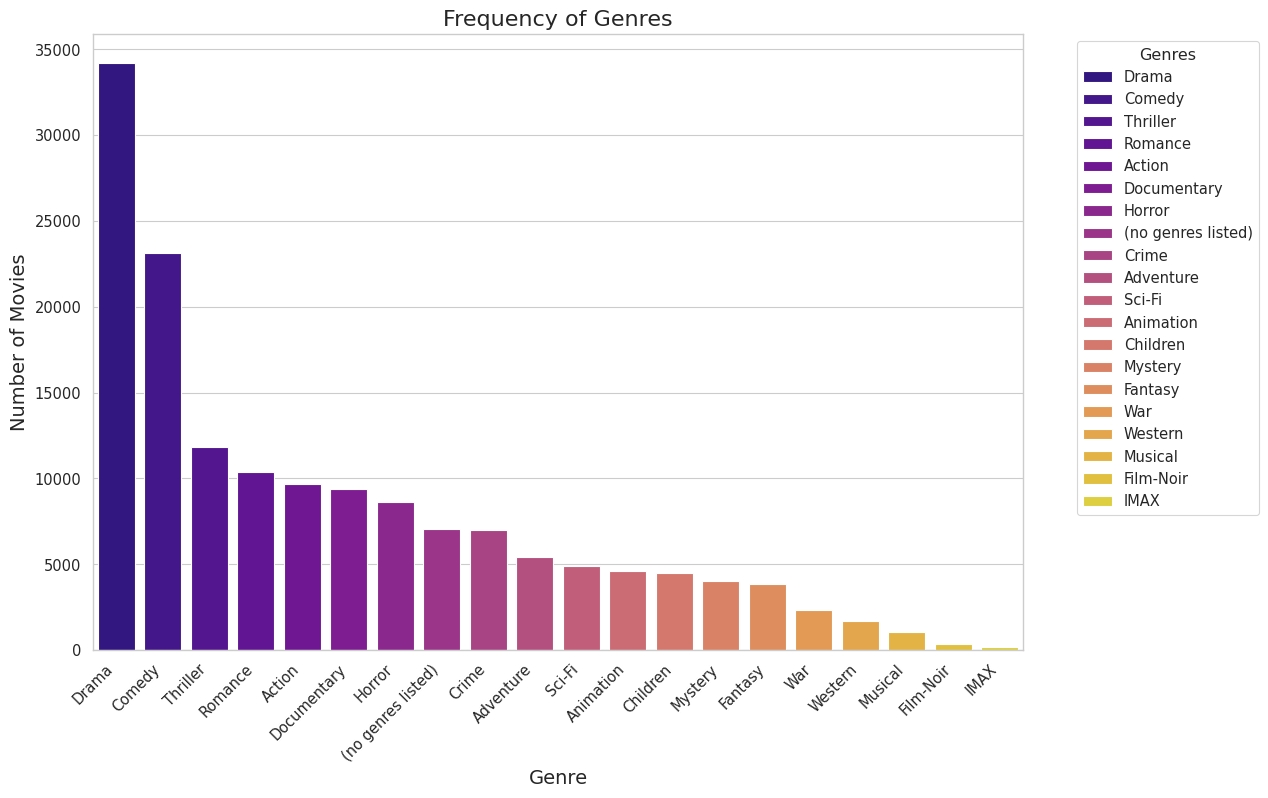

In [23]:
# Count the frequency of each genre
genre_counts = movies_df['genres'].str.split('|', expand=True).stack().value_counts()

# Setup the figure
plt.figure(figsize=(12, 8))


sns.barplot(x=genre_counts.index, y=genre_counts.values,
            hue=genre_counts.index,
            palette='plasma',
            legend=True)

# Add labels
plt.title('Frequency of Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')


plt.legend(title='Genres', bbox_to_anchor=(1.05, 1), loc='upper left')

# Save as PDF
save_path = os.path.join(FIGURES_DIR, 'genre_frequency_legend.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

Interpretation:

* The barplot shows which genres are most common in the dataset. This gives us an overview of the types of movies available and popular among users(Drama,Comedy,Thriller,Action,Romance...)

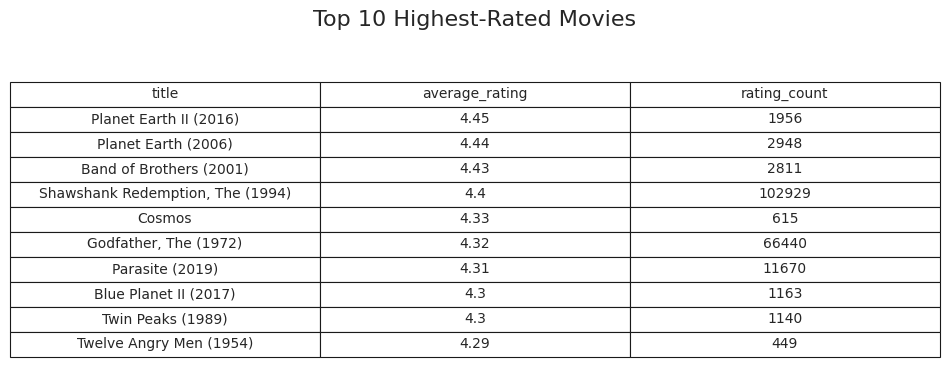

In [24]:

movie_ratings = pd.merge(ratings_df, movies_df, on='movieId')
mean_ratings = movie_ratings.groupby('title')['rating'].agg(['mean', 'count']).reset_index()
mean_ratings.columns = ['title', 'average_rating', 'rating_count']

popular_movies = mean_ratings[mean_ratings['rating_count'] >= 50].sort_values(
    by='average_rating', ascending=False
).head(10)

# Round the rating to 2 decimal places for a cleaner look
popular_movies['average_rating'] = popular_movies['average_rating'].round(2)

# --- PLOT THE TABLE ---
fig, ax = plt.subplots(figsize=(12, 4))

# Hide the axes (we only want the table, not the x/y graph lines)
ax.axis('tight')
ax.axis('off')

# Create the table
table = ax.table(cellText=popular_movies.values,
                 colLabels=popular_movies.columns,
                 loc='center',
                 cellLoc='center')

# Optional: formatting to make it look nicer
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5) # Increases row height

plt.title("Top 10 Highest-Rated Movies", y=1.1)

# Save as PDF
save_path = os.path.join(FIGURES_DIR, 'top_10_movies_table.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()

/tmp/ipython-input-1402581771.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='average_rating', y='title', data=popular_movies, palette='magma')


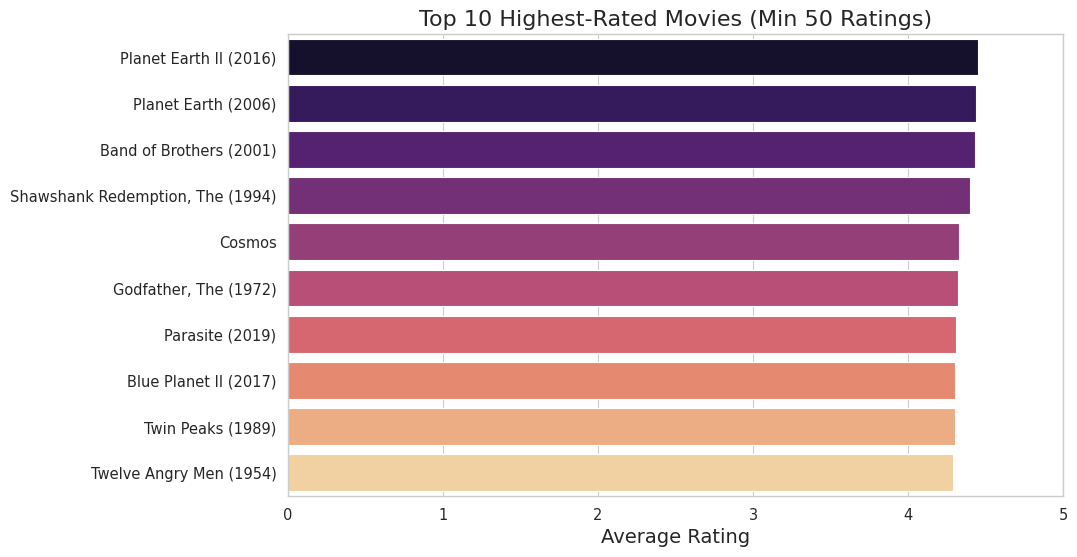

In [25]:
plt.figure(figsize=(10, 6))

# Create a Horizontal Bar Plot
sns.barplot(x='average_rating', y='title', data=popular_movies, palette='magma')

plt.title('Top 10 Highest-Rated Movies (Min 50 Ratings)')
plt.xlabel('Average Rating')
plt.ylabel('')
plt.xlim(0, 5) # Ratings are usually 0-5

# Save as PDF
save_path = os.path.join(FIGURES_DIR, 'top_10_movies_chart.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

plt.show()

Interpretation:

 * The movies at the top of the list are those that the majority of users have rated as excellent

# 6-Analysis of Tags (tags.csv)

/tmp/ipython-input-2526411855.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='coolwarm')


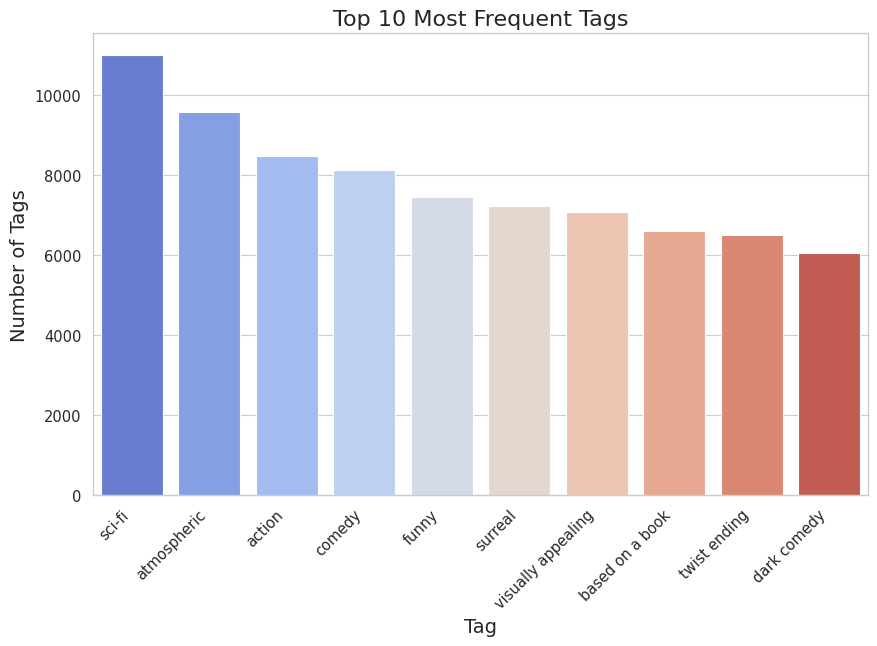

In [26]:
# Count the frequency of each tag
tag_counts = tags_df['tag'].value_counts().head(10)

# Setup the figure
plt.figure(figsize=(10, 6))

# Create the plot
sns.barplot(x=tag_counts.index, y=tag_counts.values, palette='coolwarm')

# Add labels
plt.title('Top 10 Most Frequent Tags')
plt.xlabel('Tag')
plt.ylabel('Number of Tags')
plt.xticks(rotation=45, ha='right')

# Save as PDF (Must be done BEFORE plt.show)
save_path = os.path.join(FIGURES_DIR, 'top_10_tags.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

Interpretation:

 * the most frequent tags(In Netflix queue, atmospheric,superhero,surreal)  reveal themes or characteristics that users most often associate with movies.

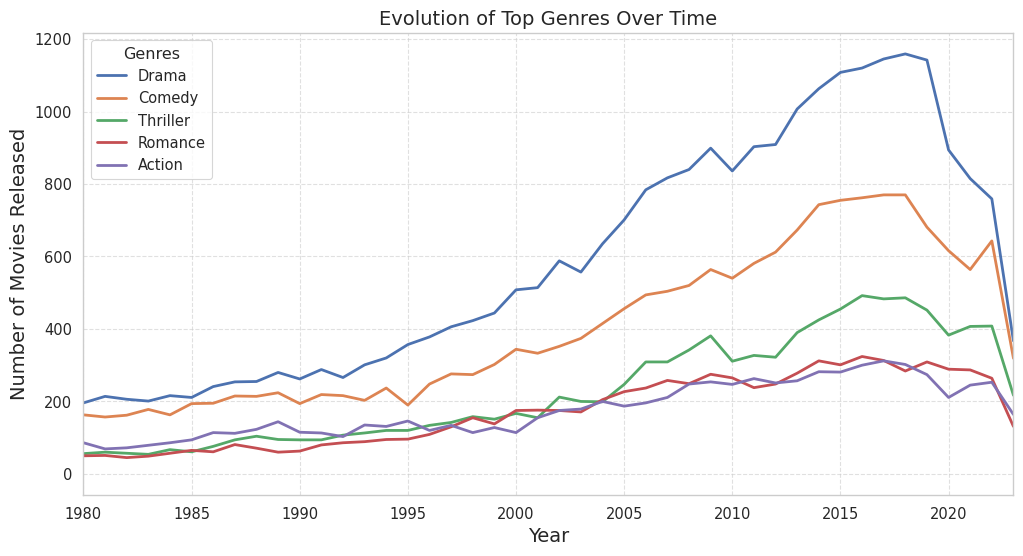

In [27]:
# 1. Extract year from title (looks for 4 digits inside parentheses)
movies_df['year'] = movies_df['title'].str.extract(r'\((\d{4})\)')
movies_df['year'] = pd.to_numeric(movies_df['year'], errors='coerce')

# 2. Drop movies where year could not be found
movies_clean = movies_df.dropna(subset=['year'])

# 3. Split genres into separate rows
movies_exploded = movies_clean.assign(genre=movies_clean['genres'].str.split('|')).explode('genre')

# 4. identify the top 5 genres
top_genres = movies_exploded['genre'].value_counts().head(5).index.tolist()


genre_trends = movies_exploded[movies_exploded['genre'].isin(top_genres)] \
    .groupby(['year', 'genre']).size().unstack(fill_value=0)


# --- PLOTTING ---

plt.figure(figsize=(12, 6))


# We plot the index (Year) against the columns (Genres)
lines = plt.plot(genre_trends.index, genre_trends[top_genres], linewidth=2)

# Add labels
plt.title('Evolution of Top Genres Over Time', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Number of Movies Released')
plt.grid(True, linestyle='--', alpha=0.6)

# Create the legend
plt.legend(lines, top_genres, title='Genres', loc='upper left')

# Limit x-axis to recent years

plt.xlim(1980, genre_trends.index.max())

# Save as PDF
save_path = os.path.join(FIGURES_DIR, 'top_10_tags.pdf')
plt.savefig('genre_evolution_over_time.pdf', format='pdf', bbox_inches='tight')

# Display
plt.show()

The 5 genres analyzed will be: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action']
Generating WordCloud for: Drama...
Generating WordCloud for: Comedy...
Generating WordCloud for: Thriller...
Generating WordCloud for: Romance...
Generating WordCloud for: Action...
Done! All PDF files have been created.


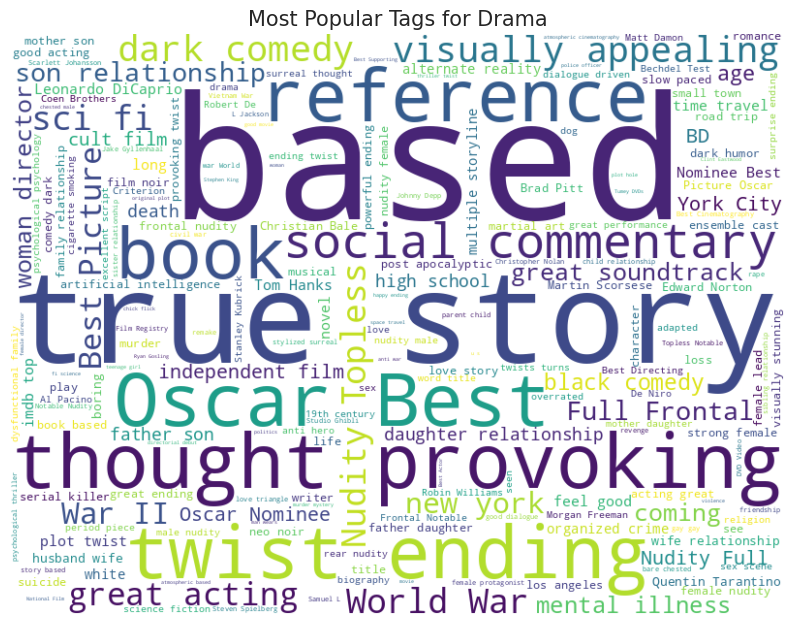

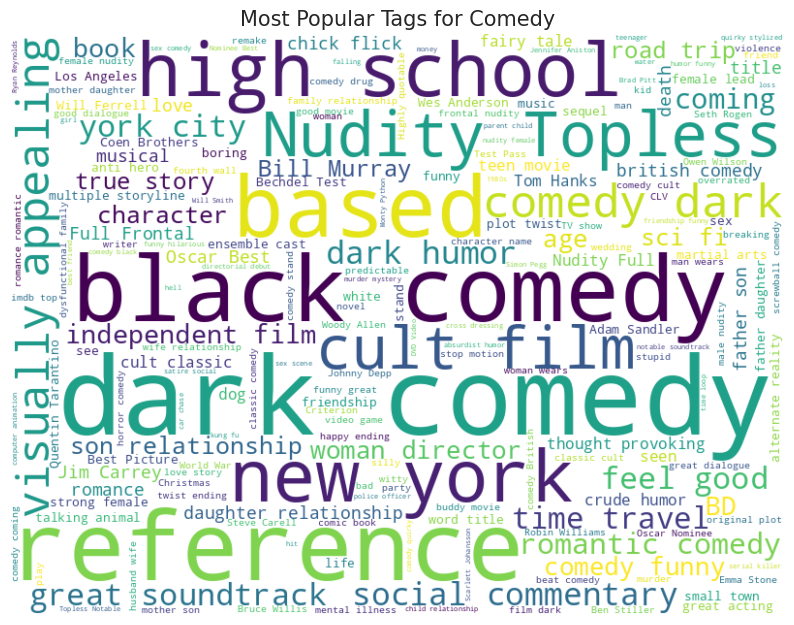

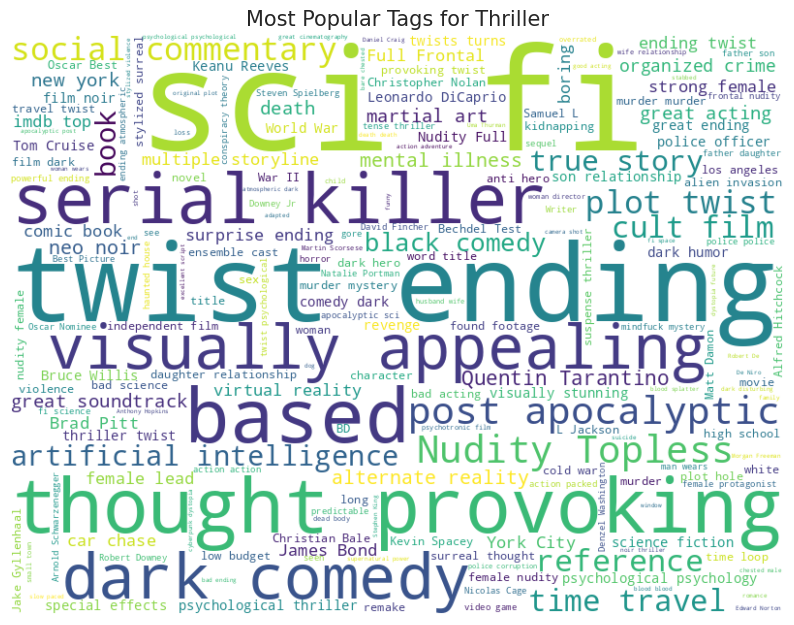

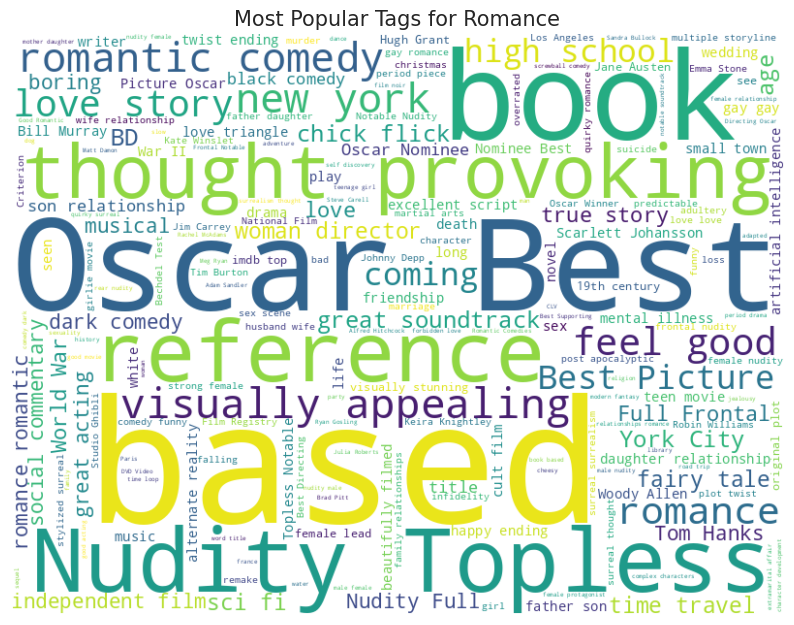

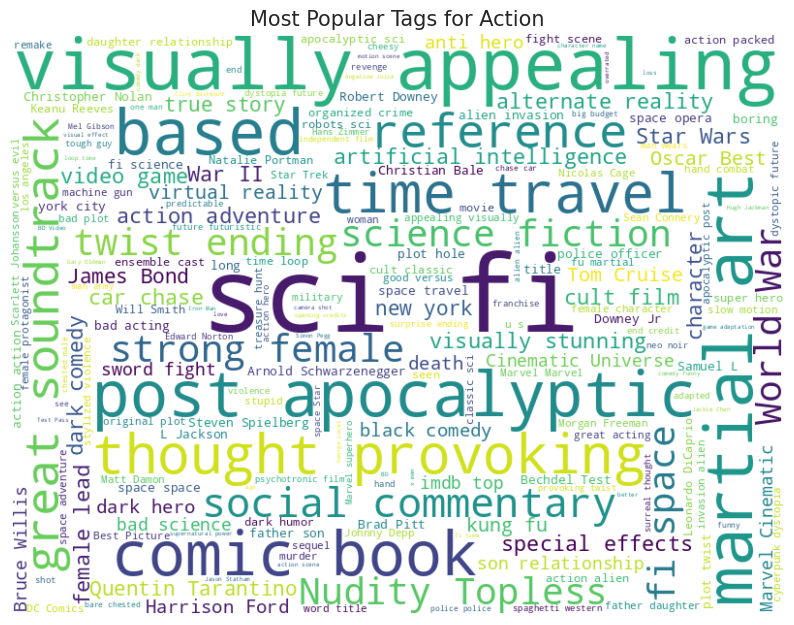

In [28]:
# 1. Merge the two DataFrames on 'movieId'
df_merged = pd.merge(movies_df, tags_df, on='movieId', how='inner')

# 2. Identify the top 5 genres
# Split the 'genres' column by '|', stack the results, count the values, and take the top 5 indices (genres)
top_genres = movies_df['genres'].str.split('|', expand=True).stack().value_counts().head(5).index.tolist()

print(f"The 5 genres analyzed will be: {top_genres}")

# 3. Loop to create and save a WordCloud for each genre
for genre in top_genres:
    print(f"Generating WordCloud for: {genre}...")

    # Filter movies that contain this genre
    # na=False avoids errors if the genre is missing/empty
    genre_tags = df_merged[df_merged['genres'].str.contains(genre, regex=False, na=False)]['tag']

    # Combine all tags into a single text string
    words = ' '.join(genre_tags.dropna().astype(str).tolist())

    # If no tags are found for this genre, skip to the next one
    if not words.strip():
        print(f"  -> No tags found for {genre}, skipping.")
        continue

    # Generate the WordCloud
    wc = WordCloud(width=800, height=600, background_color='white').generate(words)

    # Create the figure
    plt.figure(figsize=(10, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off") # Remove the axes
    plt.title(f'Most Popular Tags for {genre}', fontsize=15)

    # 4. Save as PDF
    # Clean up the file name (replace spaces or hyphens with underscores)
    safe_filename = f"wordcloud_{genre.replace('-', '_').replace(' ', '_')}.pdf"
    plt.savefig(safe_filename, format='pdf', bbox_inches='tight')

    # Display the plot
    # plt.show()

print("Done! All PDF files have been created.")
plt.show()

Genres displayed: ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action']


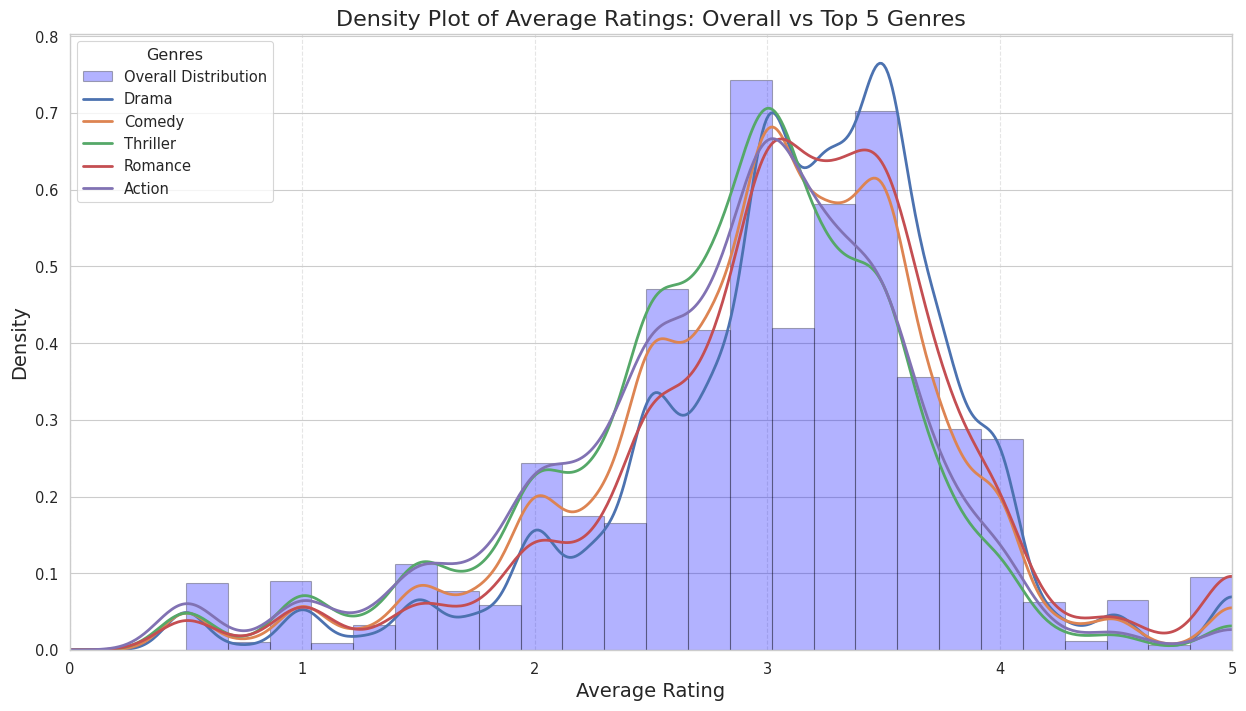

In [29]:
# 1. Data Preparation
# Calculate the average rating per movie (for all movies)
movie_means = ratings_df.groupby('movieId')['rating'].mean()

# Identify the 5 most frequent genres to prevent an unreadable graph
top_genres = movies_df['genres'].str.split('|', expand=True).stack().value_counts().head(5).index.tolist()
print(f"Genres displayed: {top_genres}")

# 2. Create the Plot
plt.figure(figsize=(15, 8))

# --- Part A: Global Histogram ---
# Display the distribution of ALL movies in the background
# density=True replaces 'normed=True' which is deprecated
movie_means.hist(bins=25, density=True, alpha=0.3, color='blue', edgecolor='black', label='Overall Distribution')

# --- Part B: KDE Curves per Genre ---
for genre in top_genres:
    # 1. Find the IDs of movies belonging to this genre
    # We use str.contains to handle the "Action|Adventure" format
    genre_movie_ids = movies_df[movies_df['genres'].str.contains(genre, regex=False, na=False)]['movieId']

    # 2. Filter the means to keep only these movies
    genre_ratings = movie_means[movie_means.index.isin(genre_movie_ids)]

    # 3. Plot the Kernel Density Estimate (KDE)
    genre_ratings.plot(kind='kde', label=genre, linewidth=2)

# 3. Formatting
plt.legend(title='Genres', loc='upper left')
plt.xlim(0, 5) # Ratings range from 0 to 5
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.title('Density Plot of Average Ratings: Overall vs Top 5 Genres')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# 4. Save as PDF
save_path = os.path.join(FIGURES_DIR, 'density_plot_ratings_by_genre.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display
plt.show()

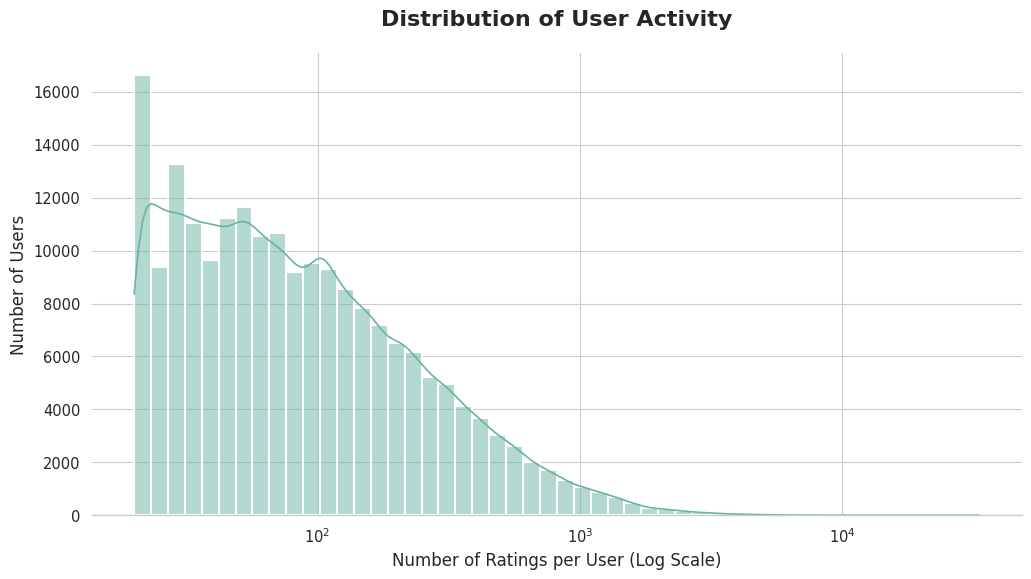

In [30]:

# 1. Setup the style
sns.set_style("whitegrid")

# 2. Calculate User Activity
user_activity = ratings_df.groupby('userId')['rating'].count().sort_values(ascending=False)

# 3. Create the plot
plt.figure(figsize=(12, 6))


sns.histplot(user_activity, bins=50, kde=True, log_scale=True,
             color='#69b3a2',
             edgecolor='white',
             linewidth=1.5)

# 4. Add labels
plt.title('Distribution of User Activity', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Ratings per User (Log Scale)', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

# Remove border clutter
sns.despine(left=True)

# 5. Save as PDF
save_path = os.path.join(FIGURES_DIR, 'user_activity_distribution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

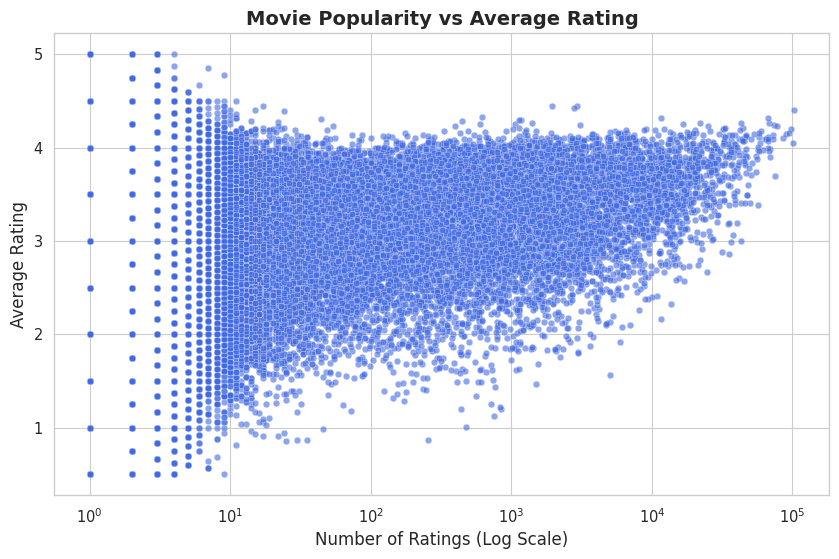

In [31]:

# 1. Calculate stats
movie_stats = ratings_df.groupby('movieId').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'num_ratings']

# 2. Setup the figure
sns.set_style("whitegrid") # Adds a clean grid background
plt.figure(figsize=(10, 6))

# 3. Create the scatter plot
# color='#4169E1' is Royal Blue
# edgecolor='white' adds a tiny white ring around each dot to separate them
plt.scatter(movie_stats['num_ratings'], movie_stats['avg_rating'],
            alpha=0.6,
            color='#4169E1',
            edgecolor='white',
            linewidth=0.3)

# 4. Axes and Labels
plt.xscale('log') # Log scale for the number of ratings
plt.title('Movie Popularity vs Average Rating', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings (Log Scale)', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)

# 5. Save as PDF
save_path = os.path.join(FIGURES_DIR, 'popularity_vs_rating.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

# 7-Datastructure

In [32]:
#Define the mapper function
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()
user_id_map = {old: new for new, old in enumerate(user_ids)}
movie_id_map = {old: new for new, old in enumerate(movie_ids)}


In [33]:
ratings_df['user_idx'] = ratings_df['userId'].map(user_id_map)
ratings_df['movie_idx'] = ratings_df['movieId'].map(movie_id_map)

In [34]:
# Compute the number of ratings per user (user degree distribution)
user_degree = ratings_df.groupby('userId').size().values

# Compute the number of ratings per movie (movie degree distribution)
movie_degree = ratings_df.groupby('movieId').size().values

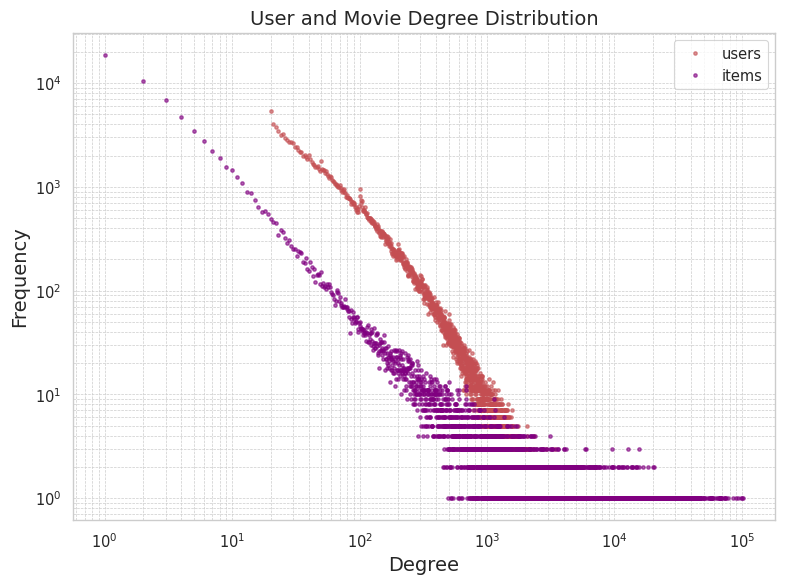

In [35]:

# Step 2: Encode user_id and movie_id to indices
user_ids = ratings_df['userId'].unique()
movie_ids = ratings_df['movieId'].unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
movie2idx = {m: i for i, m in enumerate(movie_ids)}

ratings_df['user_idx'] = ratings_df['userId'].map(user2idx)
ratings_df['movie_idx'] = ratings_df['movieId'].map(movie2idx)

# Step 3: Create user-item sparse matrix
num_users = len(user_ids)
num_movies = len(movie_ids)

user_item_matrix = csr_matrix(
    (ratings_df['rating'], (ratings_df['user_idx'], ratings_df['movie_idx'])),
    shape=(num_users, num_movies)
)

user_degree = np.array(user_item_matrix.getnnz(axis=1))  # number of items per user
item_degree = np.array(user_item_matrix.getnnz(axis=0))  # number of users per item

def degree_frequency(degree_array):
    values, counts = np.unique(degree_array, return_counts=True)
    return values, counts

user_deg, user_freq = degree_frequency(user_degree)
item_deg, item_freq = degree_frequency(item_degree)

# --- Plotting ---

plt.figure(figsize=(8, 6))
plt.title("User and Movie Degree Distribution", fontsize=14)

# 1. Changed Color: Users to Red ('r.')
plt.loglog(user_deg, user_freq, 'r.', label='users', alpha=0.6)

# 2. Changed Color: Items to Purple (using color='purple')
plt.loglog(item_deg, item_freq, '.', color='purple', label='items', alpha=0.6)

plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()

# 3. Save as PDF (Must be done BEFORE plt.show)
plt.savefig('degree_distribution_new_colors.pdf', format='pdf', bbox_inches='tight')

# Display the plot
plt.show()

In [36]:
def analyze_power_law(data, label):
    print(f"Analyzing power law fit for {label}")
    fit = powerlaw.Fit(data, xmin=20)
    print(f"Alpha (powerlaw exponent): {fit.power_law.alpha}")
    print(f"Xmin (start of power-law behavior): {fit.power_law.xmin}")

    R, p = fit.distribution_compare('power_law', 'lognormal')
    if p < 0.05 and R > 0:
        print("Power law fit is favored over lognormal distribution")
    else:
        print("Power law fit is NOT strongly favored over lognormal distribution")

    # Plot the PDF with power law fit
    fig = fit.plot_pdf(color='b', linewidth=2)
    fit.power_law.plot_pdf(color='r', linestyle='--', ax=fig)
    plt.title(f'Degree distribution and power law fit: {label}')
    plt.xlabel('Degree (Number of ratings)')
    plt.ylabel('Probability')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()
    plt.savefig(f"degree_distribution{label}.png")


Analyzing power law fit for User degree
Alpha (powerlaw exponent): 1.6922487163093345
Xmin (start of power-law behavior): 20.0


/usr/local/lib/python3.12/dist-packages/powerlaw/distributions.py:183: UserWarning: discrete=False but data exclusively contains integer values. Consider using discrete=True.
  warnings.warn('discrete=False but data exclusively contains integer values. Consider using discrete=True.')


Power law fit is NOT strongly favored over lognormal distribution


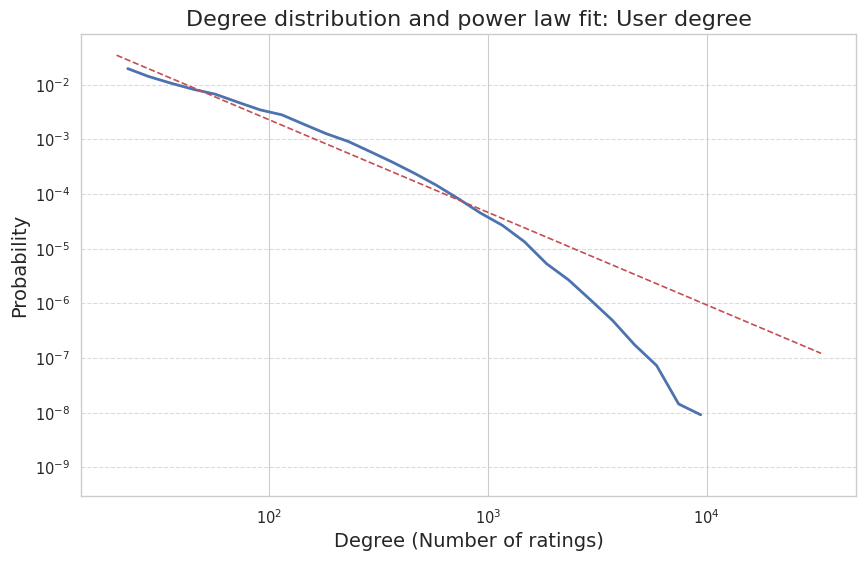

<Figure size 1000x600 with 0 Axes>

In [37]:
# Analyze user degree distribution
analyze_power_law(user_degree, "User degree")

Analyzing power law fit for Movie degree
Alpha (powerlaw exponent): 1.4563287296732774
Xmin (start of power-law behavior): 20.0
Power law fit is NOT strongly favored over lognormal distribution


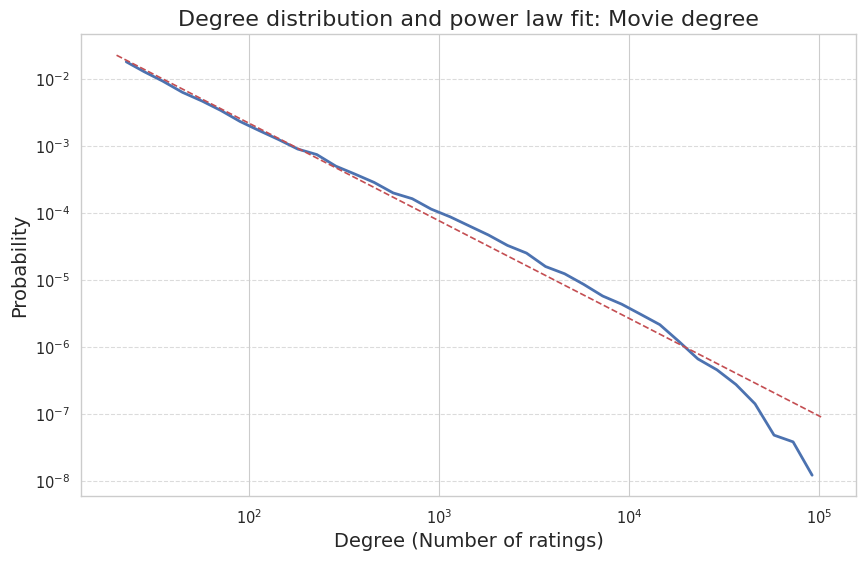

<Figure size 1000x600 with 0 Axes>

In [38]:
# Analyze movie degree distribution
analyze_power_law(movie_degree, "Movie degree")

[-] Loading data...
[-] Converting timestamps...
[+] Data Loaded. 32,000,204 ratings.
[-] Generating Plot 1: Rating Distribution...


/tmp/ipython-input-2510956662.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette="viridis")


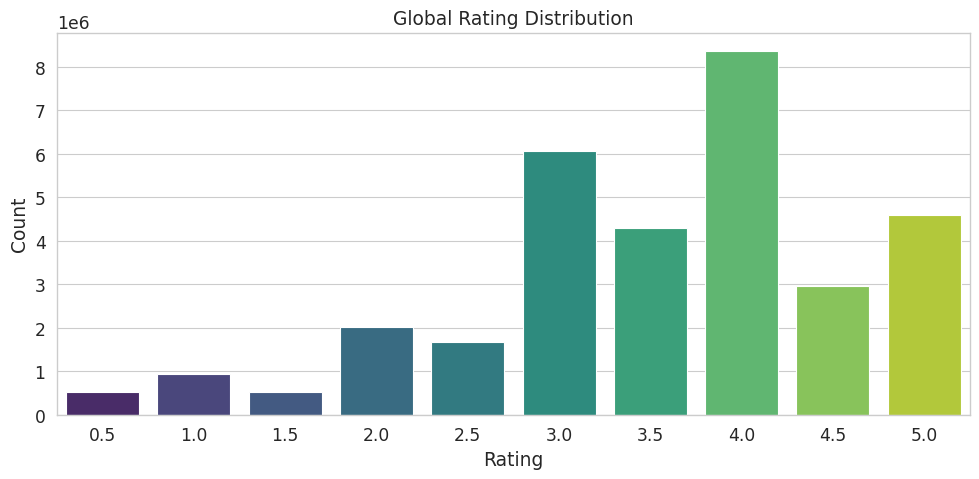

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_rating_distribution.pdf
[-] Generating Plot 2: Long Tail Distribution...


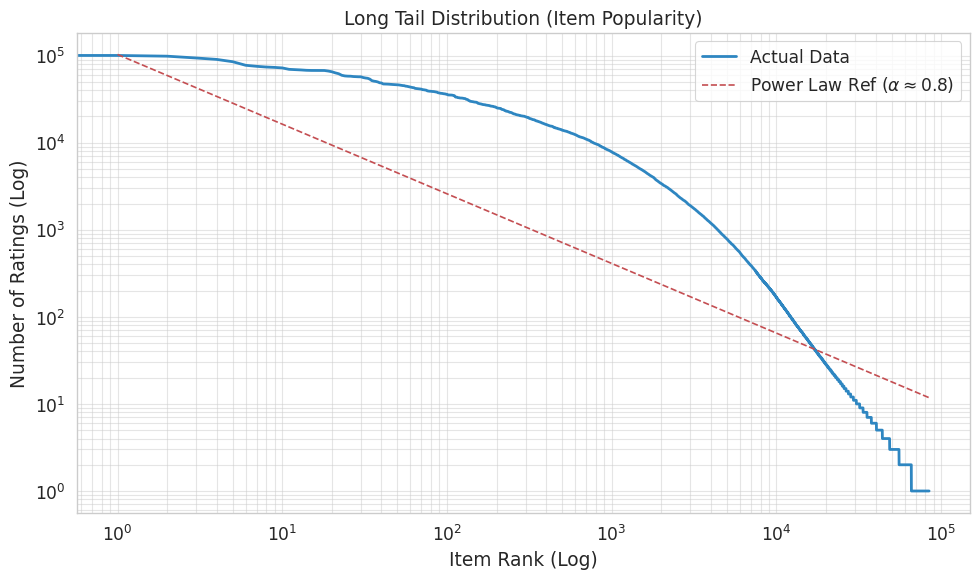

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_long_tail.pdf
[-] Generating Plot 3: Temporal Evolution...


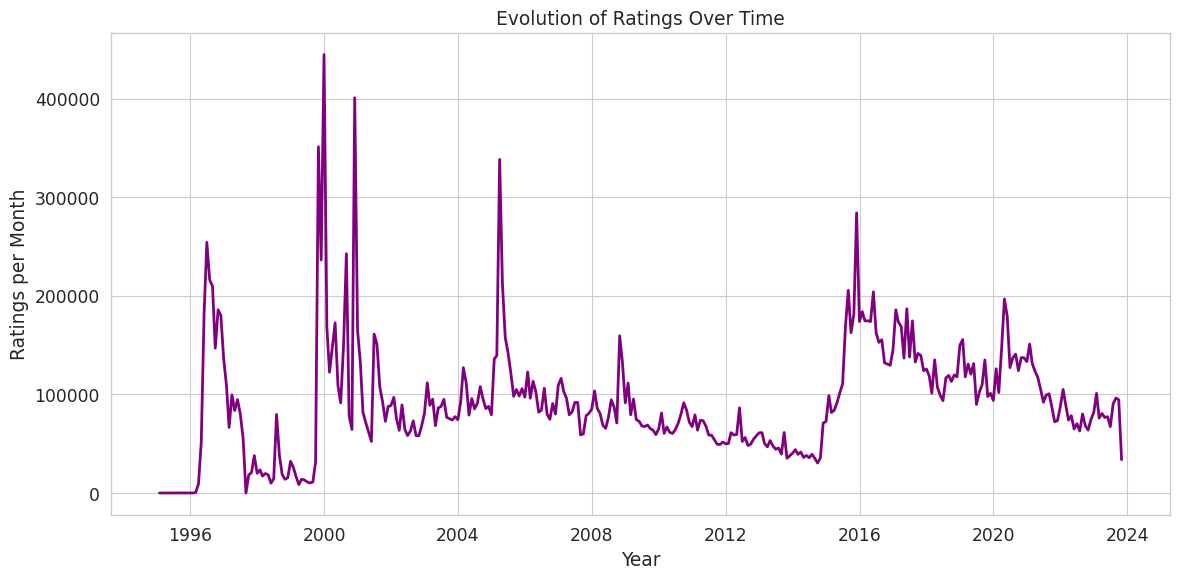

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_temporal_evolution.pdf
[-] Generating Plot 4: Interaction Heatmap...


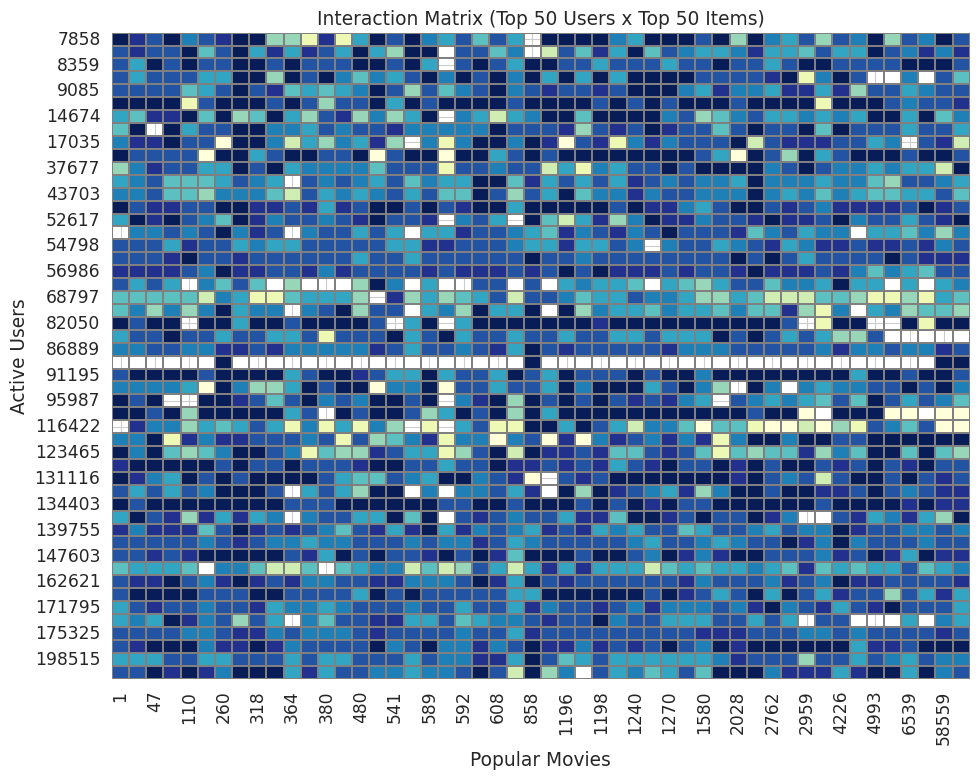

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_sparsity_heatmap.pdf
[-] Generating Plot 5: Correlation...


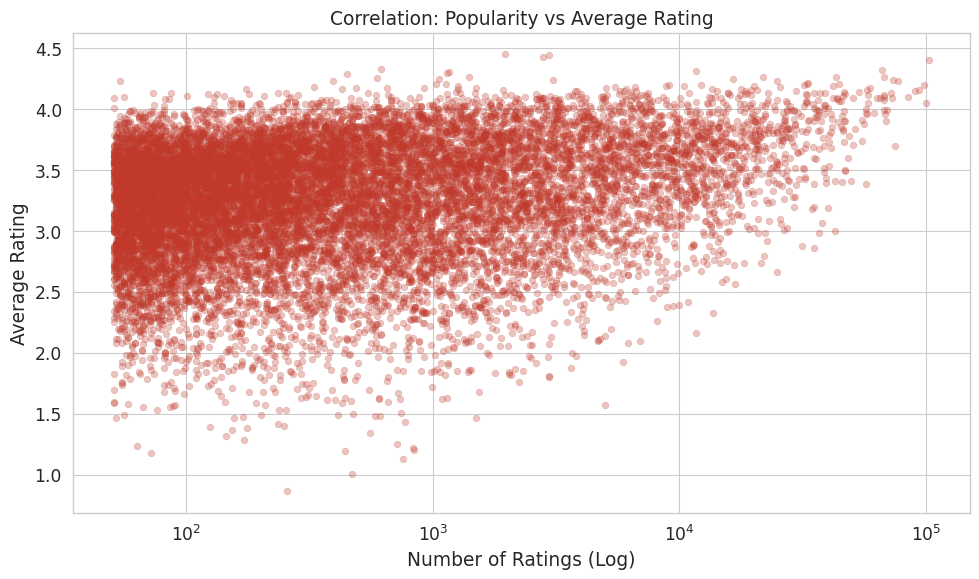

    Saved to: /content/drive/MyDrive/ML_at_scale/figures/p0_correlation.pdf
 Practical 0 Complete. All files saved to Drive.


In [39]:
# Plotting Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = (12, 6)

# --- 2. Optimized Data Loading ---
print("[-] Loading data...")

ratings_path = os.path.join(DATA_DIR, 'ratings.csv')
movies_path = os.path.join(DATA_DIR, 'movies.csv')

dtypes_ratings = {
    'userId': 'int32',
    'movieId': 'int32',
    'rating': 'float32',
    'timestamp': 'int64'
}

df_ratings = pd.read_csv(ratings_path, dtype=dtypes_ratings)
df_movies = pd.read_csv(movies_path, dtype={'movieId': 'int32'})

# Convert timestamp to date object
print("[-] Converting timestamps...")
df_ratings['date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

print(f"[+] Data Loaded. {len(df_ratings):,} ratings.")

# =========================================================
#  PLOT 1: Global Rating Distribution
# =========================================================
print("[-] Generating Plot 1: Rating Distribution...")

plt.figure(figsize=(10, 5))
counts = df_ratings['rating'].value_counts().sort_index()
sns.barplot(x=counts.index, y=counts.values, palette="viridis")

plt.title("Global Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_rating_distribution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 2: Long Tail (Power Law)
# =========================================================
print("[-] Generating Plot 2: Long Tail Distribution...")

# Get rating counts per movie
item_counts = df_ratings['movieId'].value_counts().values # Sorted Descending

plt.figure(figsize=(10, 6))
plt.plot(item_counts, color='#2E86C1', linewidth=2, label="Actual Data")

# Theoretical Reference Line (Power Law: y = k * x^-alpha)
x = np.arange(1, len(item_counts) + 1)
alpha = 0.8  # Typical slope for social data
y_ref = item_counts[0] * (x ** -alpha)
plt.plot(x, y_ref, 'r--', label=r'Power Law Ref ($\alpha \approx 0.8$)')

plt.yscale('log')
plt.xscale('log')
plt.title("Long Tail Distribution (Item Popularity)")
plt.xlabel("Item Rank (Log)")
plt.ylabel("Number of Ratings (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_long_tail.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 3: Temporal Evolution
# =========================================================
print("[-] Generating Plot 3: Temporal Evolution...")

# Resample by Month End ('ME')
monthly_counts = df_ratings.set_index('date').resample('ME').size()

plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts.values, color='purple', linewidth=2)

plt.title("Evolution of Ratings Over Time")
plt.xlabel("Year")
plt.ylabel("Ratings per Month")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_temporal_evolution.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
#  PLOT 4: Sparsity Heatmap (Top 50x50)
# =========================================================
print("[-] Generating Plot 4: Interaction Heatmap...")

top_n = 50
top_users = df_ratings['userId'].value_counts().index[:top_n]
top_items = df_ratings['movieId'].value_counts().index[:top_n]

# Filter Data (Crucial step for RAM)
mask = (df_ratings['userId'].isin(top_users)) & (df_ratings['movieId'].isin(top_items))
df_small = df_ratings[mask]

# Create Pivot Table
heatmap_matrix = df_small.pivot(index='userId', columns='movieId', values='rating')

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_matrix, cbar=False, cmap="YlGnBu", linewidths=0.05, linecolor='gray')

plt.title(f"Interaction Matrix (Top {top_n} Users x Top {top_n} Items)")
plt.xlabel("Popular Movies")
plt.ylabel("Active Users")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_sparsity_heatmap.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

# =========================================================
# PLOT 5: Popularity vs Quality Correlation
# =========================================================
print("[-] Generating Plot 5: Correlation...")

# Group by movie
movie_stats = df_ratings.groupby('movieId').agg({'rating': ['count', 'mean']})
movie_stats.columns = ['count', 'mean']

# Filter noise (movies with < 50 ratings)
robust_movies = movie_stats[movie_stats['count'] > 50]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='count', y='mean', data=robust_movies, alpha=0.3, edgecolor=None, color="#C0392B")

plt.xscale('log')
plt.title("Correlation: Popularity vs Average Rating")
plt.xlabel("Number of Ratings (Log)")
plt.ylabel("Average Rating")
plt.tight_layout()

# Save
save_path = os.path.join(FIGURES_DIR, 'p0_correlation.pdf')
plt.savefig(save_path, format='pdf', bbox_inches='tight')
plt.show()
print(f"    Saved to: {save_path}")

print(" Practical 0 Complete. All files saved to Drive.")

In [ ]:


# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)

# --- 1. Load Data ---
print("[-] Loading dataset (Pandas)...")
df = pd.read_csv(RATINGS_PATH, dtype={
    'userId': 'int32',
    'movieId': 'int32',
    'rating': 'float32'
})
print(f"[+] Loaded {len(df):,} ratings.")

# --- 2. ID Mapping (The "Map" circle on the board) ---
print("[-] Building ID Mappings...")

# Unique sorted IDs
unique_users = np.unique(df['userId'])
unique_items = np.unique(df['movieId'])

n_users = len(unique_users)
n_items = len(unique_items)

#  Board Logic: userid_to_idx = {"A": 0, "B": 1}
userid_to_idx = {original: i for i, original in enumerate(unique_users)}
movieid_to_idx = {original: i for i, original in enumerate(unique_items)}

# Board Logic: idx_to_userid = ["A", "B"]
idx_to_userid = list(unique_users)
idx_to_movieid = list(unique_items)

# Apply mapping to DataFrame for faster iteration
print("[-] Converting DataFrame columns to internal indices...")
df['u_idx'] = df['userId'].map(userid_to_idx)
df['i_idx'] = df['movieId'].map(movieid_to_idx)

# --- 3. Building Adjacency Lists (The main part of the board) ---
print(f"[-] Building 'List of Lists' structures for {n_users} users and {n_items} items...")
t0 = time.time()

# Initialize empty lists of lists
# data_by_user = [ [], [], ... ]
data_by_user = [[] for _ in range(n_users)]

# data_by_movie = [ [], [], ... ]
data_by_movie = [[] for _ in range(n_items)]

# Iterate efficiently using zip (much faster than iterrows)
# We fill both lists in one pass
# Row structure: (user_idx, item_idx, rating)
for u, i, r in zip(df['u_idx'], df['i_idx'], df['rating']):
    # Logic: data_by_user[0] = [(0, 5), (1, 2)]
    data_by_user[u].append((i, r))

    # Logic: data_by_movie[0] = [(0, 5)]
    data_by_movie[i].append((u, r))

print(f"[+] Structures built in {time.time() - t0:.2f} seconds.")

# --- Verification (Print first few like the board) ---
print("\n--- Board Verification (First User) ---")
u_idx_0 = 0
print(f"idx_to_userid[{u_idx_0}] = {idx_to_userid[u_idx_0]}")
print(f"data_by_user[{u_idx_0}] (First 5): {data_by_user[u_idx_0][:5]}")

print("\n--- Board Verification (First Movie) ---")
i_idx_0 = 0
print(f"idx_to_movieid[{i_idx_0}] = {idx_to_movieid[i_idx_0]}")
print(f"data_by_movie[{i_idx_0}] (First 5): {data_by_movie[i_idx_0][:5]}")


# --- 4. Power Law Analysis using Lists ---
print("\n[-] Calculating Degrees for Plots...")

# To get degree, we just take the length of the list!
# len(data_by_user[u]) is the number of ratings user u gave.
user_degrees = [len(ratings) for ratings in data_by_user]
item_degrees = [len(ratings) for ratings in data_by_movie]

# --- PLOT 1: Item Power Law ---
plt.figure(figsize=(10, 6))
sorted_item_degrees = np.sort(item_degrees)[::-1]
plt.plot(sorted_item_degrees, color='#2980B9', linewidth=2, label="Movie Popularity")

# Ref line
x = np.arange(1, len(sorted_item_degrees) + 1)
y_ref = sorted_item_degrees[0] * (x ** -0.8)
plt.plot(x, y_ref, 'r--', label=r'Power Law Ref ($\alpha \approx 0.8$)')

plt.xscale('log')
plt.yscale('log')
plt.title("Item Degree Distribution (Using List of Lists)")
plt.xlabel("Item Rank (Log)")
plt.ylabel("Degree (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig(os.path.join(FIGURES_DIR, 'p1_list_power_law_items.pdf'), bbox_inches='tight')
plt.show()

# --- PLOT 2: User Power Law ---
plt.figure(figsize=(10, 6))
sorted_user_degrees = np.sort(user_degrees)[::-1]
plt.plot(sorted_user_degrees, color='#27AE60', linewidth=2, label="User Activity")
plt.axhline(y=20, color='orange', linestyle=':', label="Truncation (20)")

plt.xscale('log')
plt.yscale('log')
plt.title("User Degree Distribution (Using List of Lists)")
plt.xlabel("User Rank (Log)")
plt.ylabel("Degree (Log)")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.savefig(os.path.join(FIGURES_DIR, 'p1_list_power_law_users.pdf'), bbox_inches='tight')
plt.show()

[-] Loading dataset (Pandas)...
